In [ ]:
from google.colab import drive


import pandas as pd
import numpy as np
from os import listdir
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model 
from tensorflow.keras.optimizers import Adam

In [ ]:
df = pd.read_csv(
    '/content/ipc_processed.csv', parse_dates=['date'])
df = df[df['area'] != 'rab dhuure']
df.set_index(['area', 'date'], inplace=True)
df.sort_index(inplace=True)
df['phase3_perc'] = df['phase3_perc'] + df['phase4_perc'] + df['phase5_perc']
df = df[[f'phase{i}_perc' for i in range(1, 4)]].fillna(0)
df = df.div(df.sum(axis=1), axis=0)
mask = df.reset_index().groupby('area')['date'].count() == 9

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dates = pd.Series(df.index.get_level_values(1).unique()).sort_values()
months = dates.dt.month + (dates.dt.year-2017)*12
diff = months.diff()[1:].astype(int)

In [ ]:
dates_input = []
dates_pred = []

for i, rep in enumerate((diff  + 1)):
    dates_input += rep * [dates[i]]
    dates_pred += rep * [dates[i+1]]

In [ ]:
X = []
y = []

for year in [2017, 2018]:
    dir = f'/content/drive/MyDrive/encodings/{year}_new_encoded/'
    for district in listdir(dir):
        name = district[:-4]
        if name == 'rab dhuure':
            continue

        data = np.load(dir + district)
        n_patches = data.shape[0]
        
        months = np.zeros(shape=(n_patches, 12, 16, 16, 12))
        months[:, 0, :, 0] = 1
        months[:, 1, :, 1] = 1
        for i in range(12):
            months[:, i, :, i] = i

        idx = (year-2017)*12
        prev_ipc_dist = np.zeros(shape=(n_patches, 12, 16, 16, 3))
        for i in range(12):
            prev_ipc_dist[:, i, :, :] = df.loc[name].loc[dates_input[i]].to_numpy()
            idx += 1


        data = np.concatenate((data, months, prev_ipc_dist), axis=-1)
        
        pred_data = []
        idx = (year-2017)*12
        for i in range(12):
            pred_data.append(df.loc[name].loc[dates_pred[i]].to_numpy())
            idx += 1
        labels = np.repeat(np.array(pred_data).T, n_patches).reshape(3, 12, n_patches).T.reshape(-1, 3)
        data = data.reshape(-1, 16, 16, 79)

        X.append(data)
        y.append(labels)

X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)

In [ ]:
X_val = []
y_val = []
row_idxs = []

for year in [2019]:
    dir = f'/content/drive/MyDrive/encodings/{year}_new_encoded/'
    for district in listdir(dir):
        name = district[:-4]
        if name == 'rab dhuure':
            continue

        data = np.load(dir + district)
        n_patches = data.shape[0]
        
        months = np.zeros(shape=(n_patches, 12, 16, 16, 12))
        months[:, 0, :, 0] = 1
        months[:, 1, :, 1] = 1
        for i in range(12):
            months[:, i, :, i] = i

        idx = (year-2017)*12
        prev_ipc_dist = np.zeros(shape=(n_patches, 12, 16, 16, 3))
        for i in range(12):
            prev_ipc_dist[:, i, :, :] = df.loc[name].loc[dates_input[i]].to_numpy()
            idx += 1


        data = np.concatenate((data, months, prev_ipc_dist), axis=-1)
        
        pred_data = []
        idx = (year-2017)*12
        for i in range(12):
            pred_data.append(df.loc[name].loc[dates_pred[i]].to_numpy())
            idx += 1
        labels = np.repeat(np.array(pred_data).T, n_patches).reshape(3, 12, n_patches).T.reshape(-1, 3)
        
        data = data.reshape(-1, 16, 16, 79)

        X_val.append(data)
        y_val.append(labels)

        row_idx = np.array([(name, dates_pred[(year-2017)*12 + i]) for i in range(1, 13)])
        row_idxs.append(np.repeat(row_idx.T, n_patches).reshape(2, 12, n_patches).T.reshape(-1, 2))

X_val = np.concatenate(X_val, axis=0)
y_val = np.concatenate(y_val, axis=0)
row_idxs = np.concatenate(row_idxs, axis=0)

In [ ]:
def encoder_block(x, n_filters_in, n_filters_out, n_convs=1, activation="relu", batchNorm=False):
    x_in = x
    for _ in range(n_convs):
        x = layers.Conv2D(n_filters_in, (3, 3), activation=activation, padding="same")(x)
        if batchNorm:
            x = layers.BatchNormalization()(x)
    
    if x_in.shape[-1] != x.shape[-1]:
            x_in = layers.Conv2D(n_filters_in, (1, 1), padding="same")(x_in)
    x = layers.Add()([x, x_in])

    y = layers.Conv2D(n_filters_out, (3, 3), strides=2, activation=activation, padding="same")(x)
    if batchNorm:
            y = layers.BatchNormalization()(y)
    x = layers.Conv2D(n_filters_out, (1, 1), strides=2, padding="same")(x)
    x_out = layers.Add()([y, x])
    return x_out

In [ ]:
input = layers.Input(shape=(16, 16, 79))
x = encoder_block(input, 256, 256, n_convs=2, batchNorm=True)
x = layers.Flatten()(x)
x = layers.Dense(25, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(25, activation="relu")(x)
x = layers.Dense(3, activation="softmax")(x)
model = Model(input, x)
model.compile(optimizer=Adam(learning_rate=3e-4), loss="CategoricalCrossentropy")

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 16, 16, 79)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_5 (Conv2D)              (None, 16, 16, 256)  182272      ['input_2[0][0]']                
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 16, 16, 256)  1024       ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                            

In [ ]:
history = model.fit(x=X, y=y, epochs=100, batch_size=64, shuffle=True, validation_data=(X_val, y_val))

Epoch 1/100
329/329 [==============================] - 9s 21ms/step - loss: 0.9464 - val_loss: 0.9362
Epoch 2/100
329/329 [==============================] - 6s 17ms/step - loss: 0.9191 - val_loss: 0.9182
Epoch 3/100
329/329 [==============================] - 6s 17ms/step - loss: 0.9083 - val_loss: 0.9126
Epoch 4/100
329/329 [==============================] - 6s 17ms/step - loss: 0.9028 - val_loss: 0.9088
Epoch 5/100
329/329 [==============================] - 6s 17ms/step - loss: 0.8998 - val_loss: 0.9075
Epoch 6/100
329/329 [==============================] - 6s 17ms/step - loss: 0.8978 - val_loss: 0.9056
Epoch 7/100
329/329 [==============================] - 6s 17ms/step - loss: 0.8966 - val_loss: 0.9066
Epoch 8/100
329/329 [==============================] - 6s 17ms/step - loss: 0.8955 - val_loss: 0.9026
Epoch 9/100
329/329 [==============================] - 6s 17ms/step - loss: 0.8952 - val_loss: 0.9031
Epoch 10/100
329/329 [==============================] - 6s 17ms/step - loss: 0.894

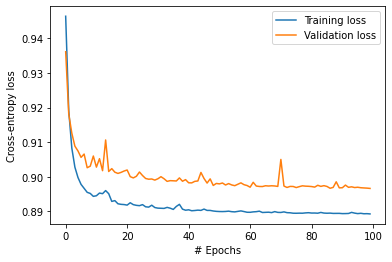

In [ ]:
fig, ax = plt.subplots()

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.legend(['Training loss', 'Validation loss'])

ax.set_xlabel('# Epochs')
ax.set_ylabel('Cross-entropy loss')

fig.savefig('ipc_downstream_loss_64.pdf', format='pdf')

In [ ]:
X_val = []
y_val = []
row_idxs = []

for year in [2019, 2020]:
    dir = f'/content/drive/MyDrive/encodings/{year}_new_encoded/'
    for district in listdir(dir):
        name = district[:-4]
        if name == 'rab dhuure':
            continue

        data = np.load(dir + district)
        n_patches = data.shape[0]
        
        months = np.zeros(shape=(n_patches, 12, 16, 16, 12))
        months[:, 0, :, 0] = 1
        months[:, 1, :, 1] = 1
        for i in range(12):
            months[:, i, :, i] = i

        idx = (year-2017)*12
        prev_ipc_dist = np.zeros(shape=(n_patches, 12, 16, 16, 3))
        for i in range(12):
            prev_ipc_dist[:, i, :, :] = df.loc[name].loc[dates_input[i]].to_numpy()
            idx += 1


        data = np.concatenate((data, months, prev_ipc_dist), axis=-1)
        
        pred_data = []
        idx = (year-2017)*12
        for i in range(12):
            pred_data.append(df.loc[name].loc[dates_pred[i]].to_numpy())
            idx += 1
        labels = np.repeat(np.array(pred_data).T, n_patches).reshape(3, 12, n_patches).T.reshape(-1, 3)
        
        data = data.reshape(-1, 16, 16, 79)

        X_val.append(data)
        y_val.append(labels)

        row_idx = np.array([(name, dates_pred[(year-2017)*12 + i]) for i in range(1, 13)])
        row_idxs.append(np.repeat(row_idx.T, n_patches).reshape(2, 12, n_patches).T.reshape(-1, 2))

X_val = np.concatenate(X_val, axis=0)
y_val = np.concatenate(y_val, axis=0)
row_idxs = np.concatenate(row_idxs, axis=0)

In [ ]:
y_pred = []
for i in range(0, len(X_val), 64):
    y_pred.append(model.predict(X_val[i:i+64]))

y_pred = np.concatenate(y_pred, axis=0)

In [ ]:
pred_df = pd.DataFrame(np.hstack([row_idxs, y_pred]))
pred_df.columns = ['area', 'date', 'phase1_perc_pred', 'phase2_perc_pred', 'phase3_perc_pred']
pred_df = pred_df.groupby(['area', 'date']).mean().join(df)

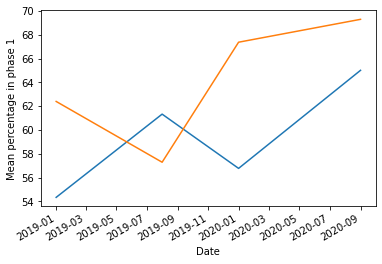

In [ ]:
fig, ax = plt.subplots()

(pred_df.groupby('date').mean()['phase1_perc_pred']*100).plot()
(pred_df.groupby('date').mean()['phase1_perc']*100).plot()

ax.set_xlabel('Date')
ax.set_ylabel('Mean percentage in phase 1')
fig.savefig('perc_1_error.pdf', format='pdf')

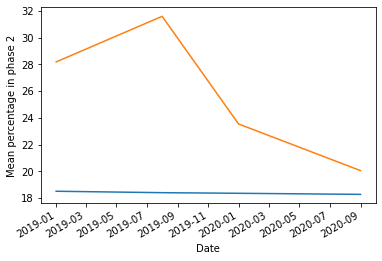

In [ ]:
fig, ax = plt.subplots()

(pred_df.groupby('date').mean()['phase2_perc_pred']*100).plot()
(pred_df.groupby('date').mean()['phase2_perc']*100).plot()

ax.set_xlabel('Date')
ax.set_ylabel('Mean percentage in phase 2')
fig.savefig('perc_2_error.pdf', format='pdf')

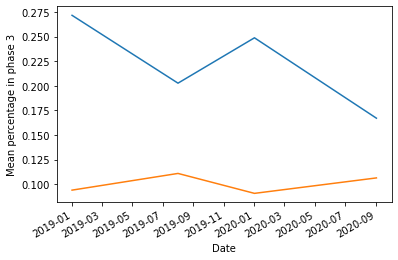

In [ ]:
fig, ax = plt.subplots()

pred_df.groupby('date').mean()['phase3_perc_pred'].plot()
pred_df.groupby('date').mean()['phase3_perc'].plot()

ax.set_xlabel('Date')
ax.set_ylabel('Mean percentage in phase 3')
fig.savefig('perc_3_error.pdf', format='pdf')